# Regression Week 5: Feature Selection and LASSO (Interpretation)

In this notebook, you will use LASSO to select features, building on a pre-implemented solver for LASSO (using GraphLab Create, though you can use other solvers). You will:
* Run LASSO with different L1 penalties.
* Choose best L1 penalty using a validation set.
* Choose best L1 penalty using a validation set, with additional constraint on the size of subset.

In the second notebook, you will implement your own LASSO solver, using coordinate descent. 

# Fire up Graphlab Create

In [1]:
import graphlab
graphlab.canvas.set_target('ipynb')

# Load in house sales data

Dataset is from house sales in King County, the region where the city of Seattle, WA is located.

In [2]:
sales = graphlab.SFrame('kc_house_data.gl/')

This non-commercial license of GraphLab Create for academic use is assigned to j.zhang@ust.hk and will expire on November 02, 2017.


[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: /tmp/graphlab_server_1479039403.log


# Create new features

As in Week 2, we consider features that are some transformations of inputs.

In [3]:
from math import log, sqrt
sales['sqft_living_sqrt'] = sales['sqft_living'].apply(sqrt)
sales['sqft_lot_sqrt'] = sales['sqft_lot'].apply(sqrt)
sales['bedrooms_square'] = sales['bedrooms']*sales['bedrooms']

# In the dataset, 'floors' was defined with type string, 
# so we'll convert them to float, before creating a new feature.
sales['floors'] = sales['floors'].astype(float) 
sales['floors_square'] = sales['floors']*sales['floors']

Using default 16 lambda workers.

To maximize the degree of parallelism, add the following code to the beginning of the program:

"graphlab.set_runtime_config('GRAPHLAB_DEFAULT_NUM_PYLAMBDA_WORKERS', 48)"

Note that increasing the degree of parallelism also increases the memory footprint.

* Squaring bedrooms will increase the separation between not many bedrooms (e.g. 1) and lots of bedrooms (e.g. 4) since 1^2 = 1 but 4^2 = 16. Consequently this variable will mostly affect houses with many bedrooms.
* On the other hand, taking square root of sqft_living will decrease the separation between big house and small house. The owner may not be exactly twice as happy for getting a house that is twice as big.

In [4]:
sales.head()

id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront
7129300520,2014-10-13 00:00:00+00:00,221900.0,3.0,1.0,1180.0,5650,1.0,0
6414100192,2014-12-09 00:00:00+00:00,538000.0,3.0,2.25,2570.0,7242,2.0,0
5631500400,2015-02-25 00:00:00+00:00,180000.0,2.0,1.0,770.0,10000,1.0,0
2487200875,2014-12-09 00:00:00+00:00,604000.0,4.0,3.0,1960.0,5000,1.0,0
1954400510,2015-02-18 00:00:00+00:00,510000.0,3.0,2.0,1680.0,8080,1.0,0
7237550310,2014-05-12 00:00:00+00:00,1225000.0,4.0,4.5,5420.0,101930,1.0,0
1321400060,2014-06-27 00:00:00+00:00,257500.0,3.0,2.25,1715.0,6819,2.0,0
2008000270,2015-01-15 00:00:00+00:00,291850.0,3.0,1.5,1060.0,9711,1.0,0
2414600126,2015-04-15 00:00:00+00:00,229500.0,3.0,1.0,1780.0,7470,1.0,0
3793500160,2015-03-12 00:00:00+00:00,323000.0,3.0,2.5,1890.0,6560,2.0,0


# Learn regression weights with L1 penalty

Let us fit a model with all the features available, plus the features we just created above.

In [5]:
all_features = ['bedrooms', 'bedrooms_square', 'bathrooms',
                'sqft_living', 'sqft_living_sqrt',
                'sqft_lot', 'sqft_lot_sqrt',
                'floors', 'floors_square',
                'waterfront', 'view', 'condition', 'grade',
                'sqft_above', 'sqft_basement',
                'yr_built', 'yr_renovated']

Applying L1 penalty requires adding an extra parameter (`l1_penalty`) to the linear regression call in GraphLab Create. (Other tools may have separate implementations of LASSO.)  Note that it's important to set `l2_penalty=0` to ensure we don't introduce an additional L2 penalty.

In [6]:
model_all = graphlab.linear_regression.create(sales, target='price', features=all_features,
                                              validation_set=None, 
                                              l2_penalty=0., l1_penalty=1e10)

Linear regression:

--------------------------------------------------------

Number of examples          : 21613

Number of features          : 17

Number of unpacked features : 17

Number of coefficients    : 18

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000002  | 3.224978     | 6962915.603493     | 426631.749026 |

| 2         | 3        | 0.000002  | 3.428713     | 6843144.200219     | 392488.929838 |

| 3         | 4        | 0.000002  | 3.618261     | 6831900.032123     | 385340.166783 |

| 4         | 5        | 0.000002  | 3.813023     | 6847166.848958     | 384842.383767 |

| 5         | 6        | 0.000002  | 3.999973     | 6869667.895833     | 385998.458623 |

| 6         | 7        | 0.000002  | 4.191593     | 6847177.773672     | 380824.455891 |

| 10        | 11       | 0.000002  | 4.894054     | 6842123.232651     | 364204.576180 |

+-----------+----------+-----------+--------------+--------------------+---------------+

TERMINATED: Iteration limit reached.

This model may not be optimal. To improve it, consider increasing `max_iterations`.

Find what features had non-zero weight.

In [7]:
model_all.coefficients.print_rows(num_rows=18)

+------------------+-------+---------------+--------+
|       name       | index |     value     | stderr |
+------------------+-------+---------------+--------+
|   (intercept)    |  None |  274873.05595 |  None  |
|     bedrooms     |  None |      0.0      |  None  |
| bedrooms_square  |  None |      0.0      |  None  |
|    bathrooms     |  None | 8468.53108691 |  None  |
|   sqft_living    |  None | 24.4207209824 |  None  |
| sqft_living_sqrt |  None | 350.060553386 |  None  |
|     sqft_lot     |  None |      0.0      |  None  |
|  sqft_lot_sqrt   |  None |      0.0      |  None  |
|      floors      |  None |      0.0      |  None  |
|  floors_square   |  None |      0.0      |  None  |
|    waterfront    |  None |      0.0      |  None  |
|       view       |  None |      0.0      |  None  |
|    condition     |  None |      0.0      |  None  |
|      grade       |  None | 842.068034898 |  None  |
|    sqft_above    |  None | 20.0247224171 |  None  |
|  sqft_basement   |  None |

In [8]:
print model_all.coefficients[model_all.coefficients['value'] != 0]['name', 'value']

+------------------+---------------+
|       name       |     value     |
+------------------+---------------+
|   (intercept)    |  274873.05595 |
|    bathrooms     | 8468.53108691 |
|   sqft_living    | 24.4207209824 |
| sqft_living_sqrt | 350.060553386 |
|      grade       | 842.068034898 |
|    sqft_above    | 20.0247224171 |
+------------------+---------------+
[? rows x 2 columns]
Note: Only the head of the SFrame is printed. This SFrame is lazily evaluated.
You can use sf.materialize() to force materialization.


Note that a majority of the weights have been set to zero. So by setting an L1 penalty that's large enough, we are performing a subset selection. 

***QUIZ QUESTION***:
According to this list of weights, which of the features have been chosen? 

# Selecting an L1 penalty

To find a good L1 penalty, we will explore multiple values using a validation set. Let us do three way split into train, validation, and test sets:
* Split our sales data into 2 sets: training and test
* Further split our training data into two sets: train, validation

Be *very* careful that you use seed = 1 to ensure you get the same answer!

In [9]:
(training_and_validation, testing) = sales.random_split(.9,seed=1) # initial train/test split
(training, validation) = training_and_validation.random_split(0.5, seed=1) # split training into train and validate

Next, we write a loop that does the following:
* For `l1_penalty` in [10^1, 10^1.5, 10^2, 10^2.5, ..., 10^7] (to get this in Python, type `np.logspace(1, 7, num=13)`.)
    * Fit a regression model with a given `l1_penalty` on TRAIN data. Specify `l1_penalty=l1_penalty` and `l2_penalty=0.` in the parameter list.
    * Compute the RSS on VALIDATION data (here you will want to use `.predict()`) for that `l1_penalty`
* Report which `l1_penalty` produced the lowest RSS on validation data.

When you call `linear_regression.create()` make sure you set `validation_set = None`.

Note: you can turn off the print out of `linear_regression.create()` with `verbose = False`

In [10]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
l1_penalty_value = np.logspace(1, 7, num=13)
best_l1_penalty = None
best_l1_model = None
RSS_value = []
min_RSS = float("inf")
for l1_penalty in l1_penalty_value:
    model = graphlab.linear_regression.create(training, 
                                              target='price', 
                                              features=all_features, 
                                              l2_penalty=0., 
                                              l1_penalty=l1_penalty, 
                                              validation_set=None, 
                                              verbose=False)
    predictions = model.predict(validation)
    errors = predictions - validation['price']
    RSS = (errors * errors).sum()
    RSS_value.append(RSS)
    print "l1_penalty %f has RSS %f with %d nonzero coefficients" % (l1_penalty, RSS, model.coefficients['value'].nnz())
    if RSS < min_RSS:
        best_l1_penalty = l1_penalty
        best_l1_model = model
        min_RSS = RSS

l1_penalty 10.000000 has RSS 625766285142460.625000 with 18 nonzero coefficients
l1_penalty 31.622777 has RSS 625766285362393.750000 with 18 nonzero coefficients
l1_penalty 100.000000 has RSS 625766286057885.125000 with 18 nonzero coefficients
l1_penalty 316.227766 has RSS 625766288257225.000000 with 18 nonzero coefficients
l1_penalty 1000.000000 has RSS 625766295212186.250000 with 18 nonzero coefficients
l1_penalty 3162.277660 has RSS 625766317206080.750000 with 18 nonzero coefficients
l1_penalty 10000.000000 has RSS 625766386760658.000000 with 18 nonzero coefficients
l1_penalty 31622.776602 has RSS 625766606749278.625000 with 18 nonzero coefficients
l1_penalty 100000.000000 has RSS 625767302791635.000000 with 18 nonzero coefficients
l1_penalty 316227.766017 has RSS 625769507643885.875000 with 18 nonzero coefficients
l1_penalty 1000000.000000 has RSS 625776517727024.250000 with 18 nonzero coefficients
l1_penalty 3162277.660168 has RSS 625799062845466.750000 with 18 nonzero coefficient

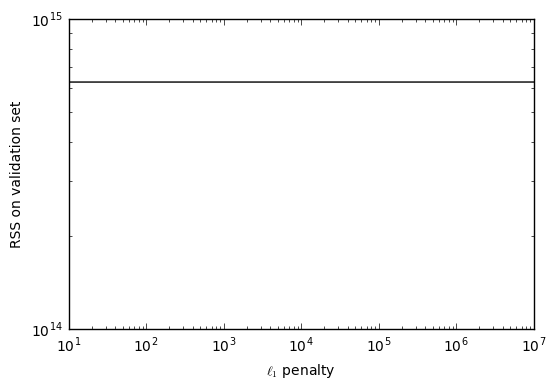

In [12]:
plt.plot(l1_penalty_value, RSS_value, 'k-')
plt.xlabel('$\ell_1$ penalty')
plt.ylabel('RSS on validation set')
plt.xscale('log')
plt.yscale('log')

*** QUIZ QUESTION. *** What was the best value for the `l1_penalty`?

In [13]:
print "Best l1_penaylty is", best_l1_penalty, "with smallest RSS one validation set", min_RSS

Best l1_penaylty is 10.0 with smallest RSS one validation set 6.25766285142e+14


***QUIZ QUESTION***
Also, using this value of L1 penalty, how many nonzero weights do you have?

In [14]:
best_l1_model.coefficients.print_rows(num_rows=18)
print "Number of nonzero weights of this l1_penalty is:", best_l1_model.coefficients['value'].nnz()

+------------------+-------+------------------+--------+
|       name       | index |      value       | stderr |
+------------------+-------+------------------+--------+
|   (intercept)    |  None |  18993.4272128   |  None  |
|     bedrooms     |  None |  7936.96767903   |  None  |
| bedrooms_square  |  None |  936.993368193   |  None  |
|    bathrooms     |  None |  25409.5889341   |  None  |
|   sqft_living    |  None |  39.1151363797   |  None  |
| sqft_living_sqrt |  None |  1124.65021281   |  None  |
|     sqft_lot     |  None | 0.00348361822299 |  None  |
|  sqft_lot_sqrt   |  None |  148.258391011   |  None  |
|      floors      |  None |   21204.335467   |  None  |
|  floors_square   |  None |  12915.5243361   |  None  |
|    waterfront    |  None |  601905.594545   |  None  |
|       view       |  None |  93312.8573119   |  None  |
|    condition     |  None |  6609.03571245   |  None  |
|      grade       |  None |  6206.93999188   |  None  |
|    sqft_above    |  None |  4

# Limit the number of nonzero weights

What if we absolutely wanted to limit ourselves to, say, 7 features? This may be important if we want to derive "a rule of thumb" --- an interpretable model that has only a few features in them.

In this section, you are going to implement a simple, two phase procedure to achive this goal:
1. Explore a large range of `l1_penalty` values to find a narrow region of `l1_penalty` values where models are likely to have the desired number of non-zero weights.
2. Further explore the narrow region you found to find a good value for `l1_penalty` that achieves the desired sparsity.  Here, we will again use a validation set to choose the best value for `l1_penalty`.

In [15]:
max_nonzeros = 7

## Exploring the larger range of values to find a narrow range with the desired sparsity

Let's define a wide range of possible `l1_penalty_values`:

In [16]:
l1_penalty_values = np.logspace(8, 10, num=20)

Now, implement a loop that search through this space of possible `l1_penalty` values:

* For `l1_penalty` in `np.logspace(8, 10, num=20)`:
    * Fit a regression model with a given `l1_penalty` on TRAIN data. Specify `l1_penalty=l1_penalty` and `l2_penalty=0.` in the parameter list. When you call `linear_regression.create()` make sure you set `validation_set = None`
    * Extract the weights of the model and count the number of nonzeros. Save the number of nonzeros to a list.
        * *Hint: `model['coefficients']['value']` gives you an SArray with the parameters you learned.  If you call the method `.nnz()` on it, you will find the number of non-zero parameters!* 

In [18]:
number_of_nonzeros_weights = []
for l1_penalty in l1_penalty_values:
    model = graphlab.linear_regression.create(training, 
                                              target='price', 
                                              features=all_features, 
                                              l2_penalty=0., 
                                              l1_penalty=l1_penalty, 
                                              validation_set=None, 
                                              verbose=False)
    number_of_nonzeros_weights.append(model.coefficients['value'].nnz())

print l1_penalty_values
print number_of_nonzeros_weights

[  1.00000000e+08   1.27427499e+08   1.62377674e+08   2.06913808e+08
   2.63665090e+08   3.35981829e+08   4.28133240e+08   5.45559478e+08
   6.95192796e+08   8.85866790e+08   1.12883789e+09   1.43844989e+09
   1.83298071e+09   2.33572147e+09   2.97635144e+09   3.79269019e+09
   4.83293024e+09   6.15848211e+09   7.84759970e+09   1.00000000e+10]
[18, 18, 18, 18, 17, 17, 17, 17, 17, 16, 15, 15, 13, 12, 10, 6, 5, 3, 1, 1]


Out of this large range, we want to find the two ends of our desired narrow range of `l1_penalty`.  At one end, we will have `l1_penalty` values that have too few non-zeros, and at the other end, we will have an `l1_penalty` that has too many non-zeros.  

More formally, find:
* The largest `l1_penalty` that has more non-zeros than `max_nonzeros` (if we pick a penalty smaller than this value, we will definitely have too many non-zero weights)
    * Store this value in the variable `l1_penalty_min` (we will use it later)
* The smallest `l1_penalty` that has fewer non-zeros than `max_nonzeros` (if we pick a penalty larger than this value, we will definitely have too few non-zero weights)
    * Store this value in the variable `l1_penalty_max` (we will use it later)


*Hint: there are many ways to do this, e.g.:*
* Programmatically within the loop above
* Creating a list with the number of non-zeros for each value of `l1_penalty` and inspecting it to find the appropriate boundaries.

In [19]:
l1_penalty_min = l1_penalty_values[max([i for i, v in enumerate(number_of_nonzeros_weights) if v > max_nonzeros])]
l1_penalty_max = l1_penalty_values[min([i for i, v in enumerate(number_of_nonzeros_weights) if v < max_nonzeros])]
print "Range of l1_penalty is: (%f, %f)" % (l1_penalty_min, l1_penalty_max)

Range of l1_penalty is: (2976351441.631313, 3792690190.732254)


***QUIZ QUESTION.*** What values did you find for `l1_penalty_min` and `l1_penalty_max`, respectively? 

In [20]:
l1_penalty_min, l1_penalty_max

(2976351441.6313133, 3792690190.7322536)

## Exploring the narrow range of values to find the solution with the right number of non-zeros that has lowest RSS on the validation set 

We will now explore the narrow region of `l1_penalty` values we found:

In [21]:
l1_penalty_values = np.linspace(l1_penalty_min,l1_penalty_max,20)

* For `l1_penalty` in `np.linspace(l1_penalty_min,l1_penalty_max,20)`:
    * Fit a regression model with a given `l1_penalty` on TRAIN data. Specify `l1_penalty=l1_penalty` and `l2_penalty=0.` in the parameter list. When you call `linear_regression.create()` make sure you set `validation_set = None`
    * Measure the RSS of the learned model on the VALIDATION set

Find the model that the lowest RSS on the VALIDATION set and has sparsity *equal* to `max_nonzeros`.

In [23]:
min_RSS = float("inf")
best_l1_penalty = None
best_model = None
for l1_penalty in l1_penalty_values:
    model = graphlab.linear_regression.create(training, 
                                              target='price', 
                                              features=all_features, 
                                              l2_penalty=0., 
                                              l1_penalty=l1_penalty, 
                                              validation_set=None, 
                                              verbose=False)
    print "Number of nonzero weights of l1_penalty %f is: %d" % (l1_penalty, model.coefficients['value'].nnz())
    if model.coefficients['value'].nnz() == max_nonzeros:
        predictions = model.predict(validation)
        errors = predictions - validation['price']
        RSS = (errors ** 2).sum()
        if RSS < min_RSS:
            min_RSS = RSS
            best_l1_penalty = l1_penalty
            best_model = model

Number of nonzero weights of l1_penalty 2976351441.631313 is: 10
Number of nonzero weights of l1_penalty 3019316638.952415 is: 10
Number of nonzero weights of l1_penalty 3062281836.273518 is: 10
Number of nonzero weights of l1_penalty 3105247033.594620 is: 10
Number of nonzero weights of l1_penalty 3148212230.915722 is: 10
Number of nonzero weights of l1_penalty 3191177428.236824 is: 10
Number of nonzero weights of l1_penalty 3234142625.557926 is: 10
Number of nonzero weights of l1_penalty 3277107822.879028 is: 10
Number of nonzero weights of l1_penalty 3320073020.200130 is: 8
Number of nonzero weights of l1_penalty 3363038217.521233 is: 8
Number of nonzero weights of l1_penalty 3406003414.842335 is: 8
Number of nonzero weights of l1_penalty 3448968612.163437 is: 7
Number of nonzero weights of l1_penalty 3491933809.484539 is: 7
Number of nonzero weights of l1_penalty 3534899006.805641 is: 7
Number of nonzero weights of l1_penalty 3577864204.126743 is: 7
Number of nonzero weights of l1_

***QUIZ QUESTIONS***
1. What value of `l1_penalty` in our narrow range has the lowest RSS on the VALIDATION set and has sparsity *equal* to `max_nonzeros`?
2. What features in this model have non-zero coefficients?

In [24]:
print best_model.coefficients[best_model.coefficients['value'] != 0]['name', 'value']

+------------------+---------------+
|       name       |     value     |
+------------------+---------------+
|   (intercept)    | 222253.192544 |
|     bedrooms     | 661.722717782 |
|    bathrooms     | 15873.9572593 |
|   sqft_living    | 32.4102214513 |
| sqft_living_sqrt | 690.114773313 |
|      grade       | 2899.42026975 |
|    sqft_above    | 30.0115753022 |
+------------------+---------------+
[? rows x 2 columns]
Note: Only the head of the SFrame is printed. This SFrame is lazily evaluated.
You can use sf.materialize() to force materialization.


In [25]:
print "Best p1_penalty is: %f" % best_l1_penalty

Best p1_penalty is: 3448968612.163437
